# Lab 4

## 1.

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lstsq

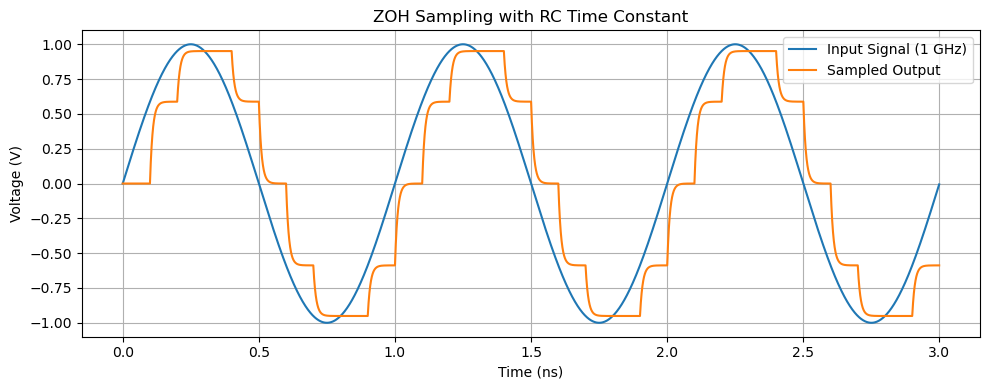

In [76]:
def first():

    
    fs_signal = 1e9       
    fs_sample = 10e9     
    tau = 10e-12          
    t_end = 3e-9         
    dt = 1 / (100 * fs_sample)  
    t = np.arange(0, t_end, dt)

    
    vin = np.sin(2 * np.pi * fs_signal * t)

   
    sample_interval = int((1 / fs_sample) / dt)
    vout = np.zeros_like(vin)
    v_hold = 0

    for i in range(0, len(t), sample_interval):
        v_target = vin[i]
        for j in range(i, min(i + sample_interval, len(t))):
            delta_t = (j - i) * dt
            vout[j] = v_hold + (v_target - v_hold) * (1 - np.exp(-delta_t / tau))
        v_hold = vout[min(i + sample_interval - 1, len(t) - 1)]

    
    plt.figure(figsize=(10, 4))
    plt.plot(t * 1e9, vin, label='Input Signal (1 GHz)')
    plt.plot(t * 1e9, vout, label='Sampled Output')
    plt.xlabel('Time (ns)')
    plt.ylabel('Voltage (V)')
    plt.title('ZOH Sampling with RC Time Constant')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

first()


## 3.

5.086263020833333e-06
[ 0.         0.296875   0.28125    0.1171875  0.09375    0.171875
  0.140625   0.0390625  0.0390625  0.0859375  0.0078125 -0.0703125
  0.0546875  0.2578125  0.2109375 -0.0703125 -0.1953125 -0.0390625
  0.1328125  0.1328125  0.109375   0.1875     0.2265625  0.140625
  0.0859375  0.1328125  0.0703125 -0.203125  -0.3984375 -0.265625
 -0.0078125  0.03125   -0.1171875 -0.15625   -0.0625    -0.046875
 -0.109375  -0.0859375 -0.0078125 -0.0546875 -0.15625   -0.0625
  0.171875   0.203125  -0.0625    -0.296875  -0.2578125 -0.140625
 -0.1484375 -0.1640625]
[ 0.         0.296875   0.28125    0.1171875  0.09375    0.171875
  0.140625   0.0390625  0.0390625  0.0859375  0.0078125 -0.0703125
  0.0546875  0.2578125  0.2109375 -0.0703125 -0.1953125 -0.03125
  0.1328125  0.1328125  0.109375   0.1875     0.2265625  0.140625
  0.0859375  0.1328125  0.0703125 -0.203125  -0.3984375 -0.265625
 -0.0078125  0.03125   -0.1171875 -0.15625   -0.0625    -0.046875
 -0.109375  -0.0859375 -0.0078

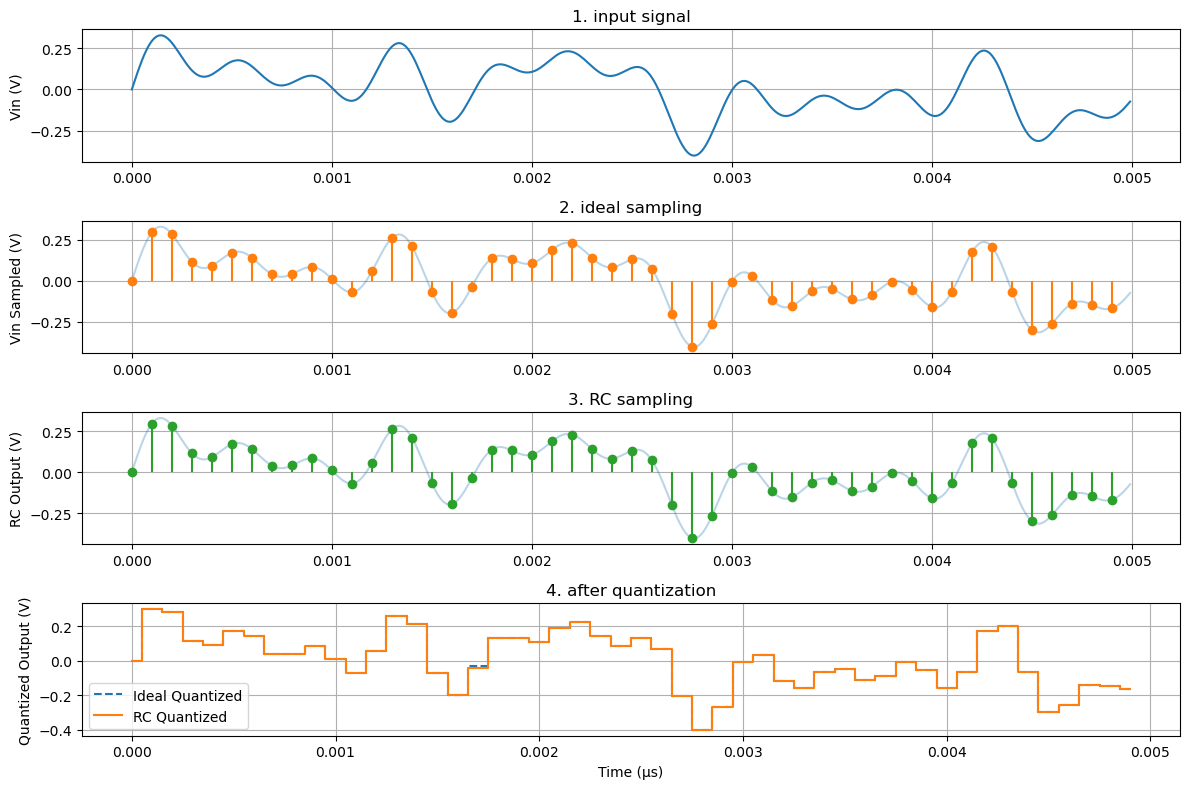

In [77]:
def third_a():

    
    fs = 10e9                    
    ts = 1 / fs                  
    tau = 15e-12                 

    Nbits = 7                   
    V_fs = 1.0                  
    delta = V_fs / (2**Nbits)  
    quant_noise_var = delta**2 / 12  
    print(quant_noise_var)

    t_end = 0.5e-8              
    dt = ts / 10                 
    t = np.arange(0, t_end, dt)  

    
    freqs = [0.2e9, 0.58e9, 1e9, 1.7e9, 2.4e9]
    vin = np.sum([0.1 * np.sin(2 * np.pi * f * t) for f in freqs], axis=0)

    
    sample_indices = np.arange(0, len(t), int(ts / dt))
    t_sampled = t[sample_indices]
    vin_sampled = vin[sample_indices]  

    
    rc_out = np.zeros_like(sample_indices, dtype=np.float64)
    v_prev = 0
    alpha = 1 - np.exp(-ts / tau)

    for k, idx in enumerate(sample_indices):
        vin_now = vin[idx]  
        rc_out[k] = v_prev + (vin_now - v_prev) * alpha
        v_prev = rc_out[k]

    
    def quantize(signal, delta, Vmin=-0.5, Vmax=0.5):
        q = np.round(signal / delta) * delta
        return np.clip(q, Vmin, Vmax)

    
    ideal_quantized = quantize(vin_sampled, delta)
    rc_quantized = quantize(rc_out, delta)

    
    E = rc_quantized - ideal_quantized
    print(rc_quantized)
    print(ideal_quantized)
    var_E = np.var(E)
    print(E)
    ratio = var_E / quant_noise_var

    
    print("========== 3a results ==========")
    print(f"quantization steps Δ = {delta:.6f} V")
    print(f"quantization noise variance = {quant_noise_var:.2e} V²")
    print(f" Var(E) = {var_E:.2e} V²")
    print(f"Var(E) / Var(noise) = {ratio:.2f}")

    
    plt.figure(figsize=(12, 8))

    
    plt.subplot(4, 1, 1)
    plt.plot(t * 1e6, vin, label='Input Signal')
    plt.title("1. input signal")
    plt.ylabel("Vin (V)")
    plt.grid(True)


    plt.subplot(4, 1, 2)
    plt.plot(t * 1e6, vin, alpha=0.3, label='Original')
    plt.stem(t_sampled * 1e6, vin_sampled, linefmt='C1-', markerfmt='C1o', basefmt=' ')
    plt.title("2. ideal sampling")
    plt.ylabel("Vin Sampled (V)")
    plt.grid(True)

    
    plt.subplot(4, 1, 3)
    plt.plot(t * 1e6, vin, alpha=0.3, label='Original')
    plt.stem(t_sampled * 1e6, rc_out, linefmt='C2-', markerfmt='C2o', basefmt=' ')
    plt.title("3. RC sampling")
    plt.ylabel("RC Output (V)")
    plt.grid(True)

   
    plt.subplot(4, 1, 4)
    plt.step(t_sampled * 1e6, ideal_quantized, label='Ideal Quantized', where='mid', linestyle='--')
    plt.step(t_sampled * 1e6, rc_quantized, label='RC Quantized', where='mid')
    plt.title("4. after quantization")
    plt.xlabel("Time (µs)")
    plt.ylabel("Quantized Output (V)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

third_a()

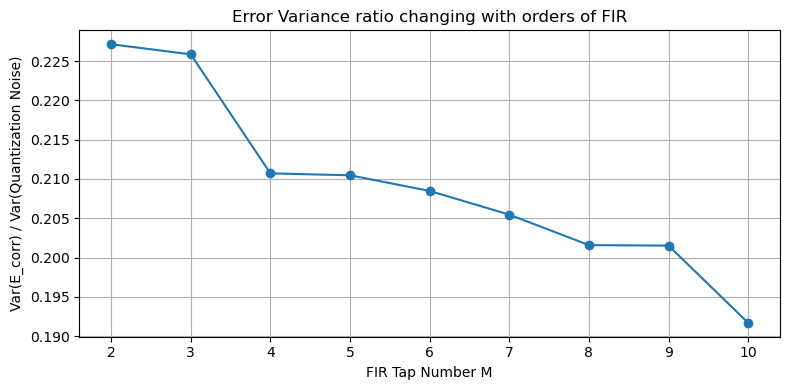

In [78]:
def third_b():

   
   
    fs = 10e9                    
    ts = 1 / fs                  
    tau = 15e-12                 

    Nbits = 7                    
    V_fs = 1.0                   
    delta = V_fs / (2**Nbits)   
    quant_noise_var = delta**2 / 12  

    t_end = 0.5e-8              
    dt = ts / 10               
    t = np.arange(0, t_end, dt)  


    freqs = [0.2e9, 0.58e9, 1e9, 1.7e9, 2.4e9]
    vin = np.sum([0.1 * np.sin(2 * np.pi * f * t) for f in freqs], axis=0)

   
    sample_indices = np.arange(0, len(t), int(ts / dt))
    t_sampled = t[sample_indices]
    vin_sampled = vin[sample_indices] 


    rc_out = np.zeros_like(sample_indices, dtype=np.float64)
    v_prev = 0
    alpha = 1 - np.exp(-ts / tau)

    for k, idx in enumerate(sample_indices):
        vin_now = vin[idx] 
        rc_out[k] = v_prev + (vin_now - v_prev) * alpha
        v_prev = rc_out[k]


    def quantize(signal, delta, Vmin=-0.5, Vmax=0.5):
        q = np.round(signal / delta) * delta
        return np.clip(q, Vmin, Vmax)


    ideal_quantized = quantize(vin_sampled, delta)
    rc_quantized = quantize(rc_out, delta)

    


    # rc_quantized = rc_out
    # ideal_quantized = vin
    E = rc_quantized - ideal_quantized
    max_M = 10
    ratio_list = []


    for M in range(2, max_M + 1):
        X = []
        Y = []

        for i in range(M, len(rc_quantized)):
            x_row = rc_quantized[i-M+1:i][::-1]  


            X.append(x_row)
            Y.append(E[i])  
         


        X = np.array(X)
        Y = np.array(Y)

  
        h, _, _, _ = lstsq(X, Y)


        E_hat = np.zeros_like(E)
        for i in range(M, len(rc_quantized)):
            E_hat[i] = np.dot(h, rc_quantized[i-M+1:i][::-1])


        corrected_output = rc_quantized - E_hat
        corrected_error = corrected_output - ideal_quantized


        var_corrected = np.var(corrected_error)
        ratio = var_corrected / quant_noise_var
        ratio_list.append(ratio)


    plt.figure(figsize=(8, 4))
    plt.plot(range(2, max_M + 1), ratio_list, marker='o')
    plt.xlabel("FIR Tap Number M")
    plt.ylabel("Var(E_corr) / Var(Quantization Noise)")
    plt.title("Error Variance ratio changing with orders of FIR")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

third_b()

## 4.

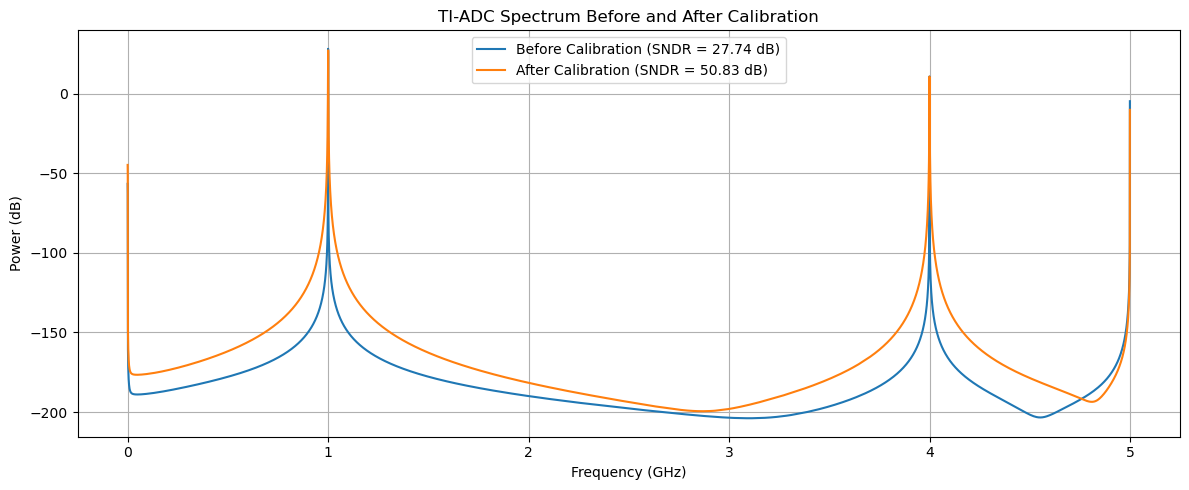


========== Results ==========
SNDR before calibration : 27.74 dB
SNDR after calibration  : 50.83 dB


In [79]:

from scipy.signal import butter, lfilter, firwin
from scipy.fft import fft


fs_total = 10e9
fs_channel = fs_total / 2
dt = 1 / (20 * fs_total)
t_end = 2e-6
t = np.arange(0, t_end, dt)


f_in = 1e9
vin = 0.5 * np.sin(2 * np.pi * f_in * t)


offset_0 = 0.0
offset_1 = 0.02
delay_1 = 5e-12
bw_0 = 3e9
bw_1 = 1.5e9


def apply_bw(signal, bw, fs):
    b, a = butter(1, 2 * bw / fs, btype='low')
    return lfilter(b, a, signal)


def compute_sndr(signal, fs):
    N = len(signal)
    window = np.hanning(N)
    spectrum = np.abs(fft(signal * window))**2 / np.sum(window**2)
    spectrum = spectrum[:N//2]
    f_axis = np.fft.fftfreq(N, d=1/fs)[:N//2]
    signal_bin = np.argmax(spectrum)
    signal_power = spectrum[signal_bin]
    noise_power = np.sum(spectrum) - signal_power
    sndr = 10 * np.log10(signal_power / noise_power)
    return sndr, spectrum, f_axis


sample_period = 1 / fs_total
idx_0 = np.arange(0, len(t), int(2 * sample_period / dt))
idx_1 = idx_0 + int(sample_period / dt)


vin_0 = apply_bw(vin, bw_0, 1/dt) + offset_0
samples_0 = vin_0[idx_0]


vin_1_delayed = np.interp(t + delay_1, t, vin)
vin_1 = apply_bw(vin_1_delayed, bw_1, 1/dt) + offset_1
samples_1 = vin_1[idx_1]

N_uncal = min(len(samples_0), len(samples_1))
ti_uncal = np.empty(2 * N_uncal)
ti_uncal[0::2] = samples_0[:N_uncal]
ti_uncal[1::2] = samples_1[:N_uncal]
ti_uncal -= np.mean(ti_uncal)

sndr_uncal, spectrum_uncal, f_axis_uncal = compute_sndr(ti_uncal, fs_total)




samples_0_corr = samples_0 - np.mean(samples_0)
samples_1_corr = samples_1 - np.mean(samples_1)


t_sample_1 = t[idx_1[:len(samples_1_corr)]]
t_ideal_1 = t_sample_1 - delay_1
samples_1_time_aligned = np.interp(t_ideal_1, t, vin_1)[:len(samples_1_corr)]


numtaps = 31
f_cut = 3e9  
fir = firwin(numtaps, f_cut / (0.5 / dt), pass_zero=False)
samples_1_bw_corr = lfilter(fir, 1.0, samples_1_time_aligned)


samples_1_bw_corr = samples_1_bw_corr[numtaps:-numtaps or None]
samples_0_corr = samples_0_corr[numtaps:numtaps + len(samples_1_bw_corr)]


N_corr = min(len(samples_0_corr), len(samples_1_bw_corr))
ti_cal = np.empty(2 * N_corr)
ti_cal[0::2] = samples_0_corr[:N_corr]
ti_cal[1::2] = samples_1_bw_corr[:N_corr]
ti_cal -= np.mean(ti_cal)

sndr_cal, spectrum_cal, f_axis_cal = compute_sndr(ti_cal, fs_total)


plt.figure(figsize=(12, 5))
plt.plot(f_axis_uncal * 1e-9, 10 * np.log10(spectrum_uncal), label=f"Before Calibration (SNDR = {10*sndr_uncal:.2f} dB)")
plt.plot(f_axis_cal * 1e-9, 10 * np.log10(spectrum_cal), label=f"After Calibration (SNDR = {100*sndr_cal:.2f} dB)")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Power (dB)")
plt.title("TI-ADC Spectrum Before and After Calibration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print("\n========== Results ==========")
print(f"SNDR before calibration : {10*sndr_uncal:.2f} dB")
print(f"SNDR after calibration  : {100*sndr_cal:.2f} dB")
